<a href="https://colab.research.google.com/github/Malekkamoua/PFE/blob/main/.addixo/5_Forecasting_%7C_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
df = pd.read_csv('/content/gdrive/MyDrive/Datascience/PFE/datasets/addixo_final_dataset_fs_db.csv', parse_dates=['dates'],  index_col='dates',infer_datetime_format=True)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


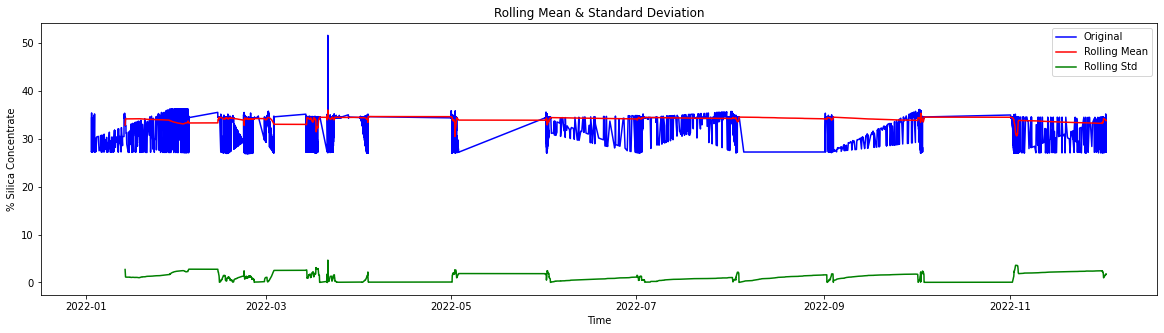

Results of Dickey-Fuller Test:
Test Statistic                -1.613006e+01
p-value                        4.796013e-29
#Lags Used                     6.400000e+01
Number of Observations Used    8.158200e+04
Critical Value (1%)           -3.430430e+00
Critical Value (5%)           -2.861575e+00
Critical Value (10%)          -2.566789e+00
dtype: float64
The timeseries is stationary at 95% level of confidence


In [5]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, rolling):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(rolling).mean()
    rolstd = timeseries.rolling(rolling).std()

    #Plot rolling statistics:
    plt.figure(figsize=(20, 5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label = 'Rolling Std')

    plt.xlabel('Time')
    plt.ylabel('% Silica Concentrate')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:') 
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dfoutput['p-value'] < 0.05:
        print('The timeseries is stationary at 95% level of confidence')
    else:
        print('The timeseries is not stationary at 95% level of confidence')
  

test_stationarity(df['duration'], rolling=1000)


Stationarity can be defined in precise mathematical terms, but for our purpose we mean a flat looking series, without trend, constant variance over time, a constant autocorrelation structure over time and no periodic fluctuations (seasonality).

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
import time

values = df[['duration']].values

# Normalization
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(values)

# 70% 15% 15%
# 70% 15% 15%

train, test, val = scaled_data[0:57153], scaled_data[57153:12247], scaled_data[12247:]
history_test = [x for x in train]

predictions = list()
# walk-forward validation
start = time.time()

for t in range(len(test)):
	model = ARIMA(history_test, order=(1,1,1))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history_test.append(obs)
 
history_val = [x for x in train]

predictions_val = list()
# walk-forward validation
for t in range(len(val)):
	model = ARIMA(history_val, order=(1,1,1))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions_val.append(yhat)
	obs = val[t]
	history_val.append(obs)

stop = time.time()

In [ ]:
print(f"Training time: {stop - start}s")

Training time: 2443.236275434494s


In [ ]:
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  
    mae = np.mean(np.abs(forecast - actual))    
    rmse = np.mean((forecast - actual)**2)**.5  

    return mape, mae, rmse

In [ ]:
Inverse_test = test.reshape(-1,1)
Inverse_test = scaler.inverse_transform(Inverse_test)
Inverse_predictions = predictions
Inverse_predictions = scaler.inverse_transform(Inverse_predictions)

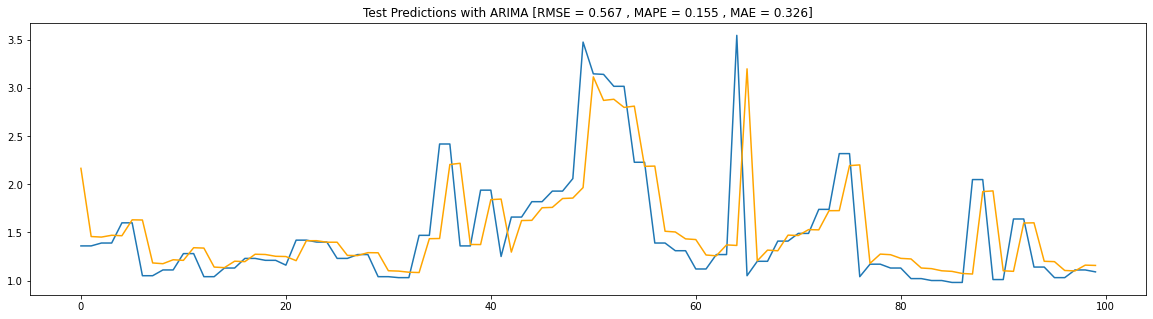

In [ ]:
from matplotlib import pyplot

mape, mae, rmse = forecast_accuracy(Inverse_predictions, Inverse_test)

fig, ax = plt.subplots(figsize=(20,5))

# plot forecasts against actual outcomes
pyplot.plot(Inverse_test[0:100])
pyplot.plot(Inverse_predictions[0:100], color='orange')
plt.title("Test Predictions with ARIMA [RMSE = %.3f , MAPE = %.3f , MAE = %.3f]" % (rmse, mape, mae) )
pyplot.show()

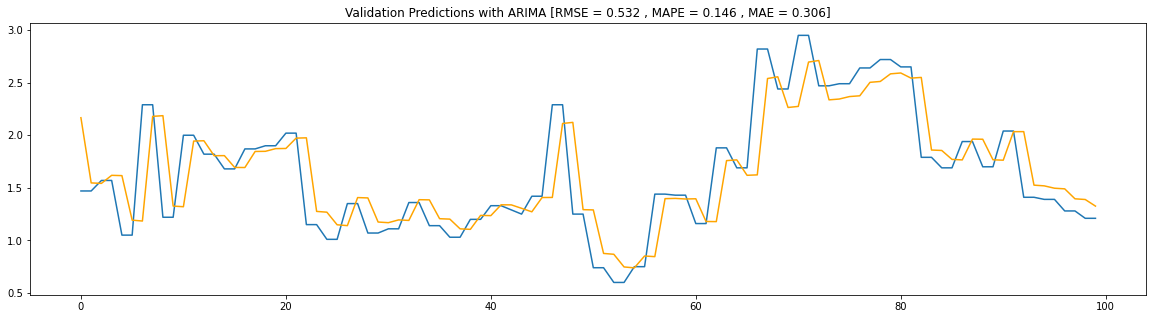

In [ ]:
Inverse_val = val.reshape(-1,1)
Inverse_val = scaler.inverse_transform(Inverse_val)
Inverse_predictions = predictions_val
Inverse_predictions = scaler.inverse_transform(Inverse_predictions)

mape, mae, rmse = forecast_accuracy(Inverse_predictions, Inverse_val)

fig, ax = plt.subplots(figsize=(20,5))

# plot forecasts against actual outcomes
pyplot.plot(Inverse_val[0:100])
pyplot.plot(Inverse_predictions[0:100], color='orange')
plt.title("Validation Predictions with ARIMA [RMSE = %.3f , MAPE = %.3f , MAE = %.3f]" % (rmse, mape, mae) )
pyplot.show()

In [ ]:
''' from pmdarima.arima import auto_arima

test = auto_arima(train, start_p=1, start_q=1,
                      test='adf',
                      max_p=5, max_q=5,
                      m=1,             
                      d=1,          
                      seasonal=True,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True) 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4898.862, Time=6.85 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4583.398, Time=1.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4693.561, Time=1.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4736.923, Time=2.56 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4585.398, Time=0.37 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=14.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=8.54 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4822.356, Time=1.67 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4767.978, Time=3.70 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4896.951, Time=5.97 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4900.863, Time=1.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4738.922, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4695.560, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=2.93 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=2.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-4824.355, Time=0.66 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-4769.978, Time=0.81 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=3.33 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 57.730 seconds '''